# Boosting with AdaBoost and Decision Tree Analysis

In [62]:
#imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report


In [2]:
shoes = pd.read_csv('datasets/shoes_data.csv')

In [3]:
shoes.head()

,title_token,title_tokens_merged,subreddit
0,"['ordered', 'a', 'pair', 'of', 'these', 'my', ...",ordered a pair of these my first 327 s im in love,Newbalance
1,"['started', 'grey', 'day', 'getting', 'a', 'li...",started grey day getting a lil hooked,Newbalance
2,"['started', 'grey', 'day', 'getting', 'a', 'li...",started grey day getting a lil hooked,Newbalance
3,"['started', 'on', 'grey', 'day', 'getting', 'a...",started on grey day getting a lil hooked,Newbalance
4,"['when', 'will', 'these', 'drop', 'on', 'the',...",when will these drop on the nb website i have ...,Newbalance


In [4]:
shoes.isnull().sum()

title_token            0
title_tokens_merged    0
subreddit              0
dtype: int64

In [5]:
shoes = shoes.dropna()

### Define X and y

In [6]:
X = shoes['title_tokens_merged']
y = shoes['subreddit']

## Baseline score (score to beat)

In [7]:
y.value_counts(normalize=True)

Newbalance    0.500251
Nike          0.499749
Name: subreddit, dtype: float64

### Split the data into train and test data 

In [8]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

### Instantiate the Count Vectorizer 

In [9]:
# Instantiate a CountVectorizer.
cv = CountVectorizer(stop_words='english')

### Fit the train data onto the Count Vectorizer (transformer)

In [10]:
cv.fit(X_train)

CountVectorizer(stop_words='english')

### Start analysis by transforming the corpus with the Count Vectorizer 

In [11]:
# Transform the corpus.
X_train = cv.transform(X_train)

In [12]:
X_test = cv.transform(X_test)

### Instantiate the Decision Tree Classifier and fit the train data 

In [13]:
dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train), dtc.score(X_test, y_test)

(DecisionTreeClassifier(), 0.7051671732522796)

### Instantiate the Ada Boost Classifier and fit 

In [14]:
abc = AdaBoostClassifier(random_state=42, n_estimators=150)

abc.fit(X_train, y_train)

abc.score(X_train, y_train), abc.score(X_test, y_test)

(0.9116104868913858, 0.7887537993920972)

In [15]:
abc.feature_importances_

array([0., 0., 0., ..., 0., 0., 0.])

In [16]:
sum(abc.feature_importances_ != 0)

138

In [17]:
cv_feature_names = cv.get_feature_names()

### Create dataframe with importance ratings of each word from Ada Boost Classifier

In [18]:
ada_imps = pd.DataFrame({
    'word': cv_feature_names,
    'importance': abc.feature_importances_
})
ada_imps

,word,importance
0,00,0.0
1,001,0.0
2,0011,0.0
3,00am,0.0
4,07,0.0
...,...,...
2177,zag,0.0
2178,zig,0.0
2179,zip,0.0
2180,zone,0.0


### Sort importance values from highest to lowest

In [19]:
ada_imps.sort_values(by='importance', ascending=False).head(15)

,word,importance
989,identify,0.013333
336,black,0.013333
1876,sure,0.013333
302,balance,0.013333
643,does,0.013333
1995,trying,0.013333
1953,today,0.013333
1348,nike,0.013333
1124,legit,0.013333
1164,look,0.013333


### Create dataframe of the predictions 

In [20]:
test_preds = abc.predict(X_test)

In [21]:
pred_df = pd.DataFrame(test_preds)

In [22]:
pred_df

,0
0,Newbalance
1,Newbalance
2,Newbalance
3,Newbalance
4,Newbalance
...,...
653,Nike
654,Nike
655,Nike
656,Nike


### Plot the decision trees by each learner 

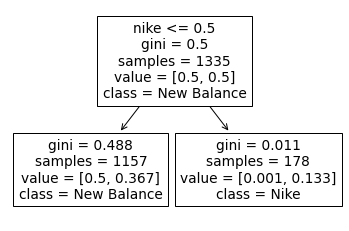

In [65]:
plot_tree(abc.estimators_[0], feature_names=cv_feature_names, class_names=['New Balance', 'Nike']);
plt.savefig('visuals/forest_diagram.jpeg')

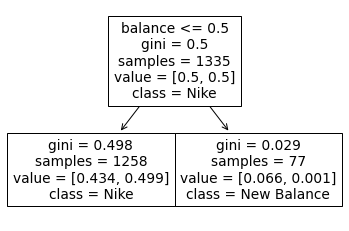

In [66]:
plot_tree(abc.estimators_[1], feature_names=cv_feature_names, class_names=['New Balance', 'Nike']);

### Refine the training and test data 

In [27]:
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

### Pipeline analysis of shoes dataset with Count Vectorizer and Ada Boost Classifier  

In [70]:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english')), 
    ('abc', AdaBoostClassifier())
    
])

In [37]:
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.8307116104868913, 0.7811550151975684)

### Create dataframe of the predictions 

In [38]:
test_preds = pipe.predict(X_test)

In [39]:
pred_df = pd.DataFrame({'test': X_test.values, 'true label':y_test.values, 'predicted label':test_preds})

In [40]:
pred_df

,test,true label,predicted label
0,beat the everliving shit out of these tending ...,Newbalance,Newbalance
1,wide footer question,Newbalance,Newbalance
2,m990ry v4 cameo because my dad came by with so...,Newbalance,Newbalance
3,f you new balance,Newbalance,Newbalance
4,couple dope 574 i picked up recently,Newbalance,Newbalance
...,...,...,...
653,hey guys i ve got a pair of nike dunk high rai...,Nike,Nike
654,can anyone id these for me,Newbalance,Newbalance
655,would you guys file a warranty return on this ...,Nike,Nike
656,how do you guys feel on the purple pulses i pi...,Nike,Nike


### Create dataframe with only the incorrectly predicted values

In [41]:
pred_df[pred_df['true label'] != pred_df['predicted label']].head(15)

,test,true label,predicted label
5,id on those pls,Nike,Newbalance
6,to those of you with the auralee 550s does you...,Newbalance,Nike
7,does anyone know what model this is,Newbalance,Nike
8,any idea what these might be worth,Nike,Newbalance
9,which model is this,Nike,Newbalance
11,fire 97 for only 100,Nike,Newbalance
21,is this okay,Nike,Newbalance
31,what are those sorry for the bad image quality...,Nike,Newbalance
33,need help,Newbalance,Nike
35,adidas is ten times better,Nike,Newbalance


### Plot the misclassifications with a confusion matrix 

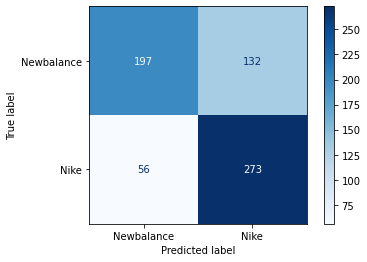

In [63]:
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format='d');
plt.savefig('visuals/confusion_matrix_cv_ada.jpeg')

### Get the report of the predictions including precision, accuracy, etc. 

In [48]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

  Newbalance       0.73      0.90      0.80       329
        Nike       0.87      0.66      0.75       329

    accuracy                           0.78       658
   macro avg       0.80      0.78      0.78       658
weighted avg       0.80      0.78      0.78       658



### Refine the training and test data 

In [50]:
# Redefine training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

### Pipeline analysis of shoes dataset with Count Vectorizer and Decision Tree Classifier  

In [53]:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english')), 
    ('dtc', DecisionTreeClassifier()),
    
])

In [54]:
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.9955056179775281, 0.7142857142857143)

### Create dataframe of the predictions 

In [55]:
test_preds = pipe.predict(X_test)

In [56]:
pred_df = pd.DataFrame({'test': X_test.values, 'true label':y_test.values, 'predicted label':test_preds})

In [57]:
pred_df

,test,true label,predicted label
0,beat the everliving shit out of these tending ...,Newbalance,Nike
1,wide footer question,Newbalance,Newbalance
2,m990ry v4 cameo because my dad came by with so...,Newbalance,Newbalance
3,f you new balance,Newbalance,Newbalance
4,couple dope 574 i picked up recently,Newbalance,Newbalance
...,...,...,...
653,hey guys i ve got a pair of nike dunk high rai...,Nike,Nike
654,can anyone id these for me,Newbalance,Nike
655,would you guys file a warranty return on this ...,Nike,Newbalance
656,how do you guys feel on the purple pulses i pi...,Nike,Newbalance


### Create dataframe with only the incorrectly predicted values

In [58]:
pred_df[pred_df['true label'] != pred_df['predicted label']].head(15)

,test,true label,predicted label
0,beat the everliving shit out of these tending ...,Newbalance,Nike
5,id on those pls,Nike,Newbalance
6,to those of you with the auralee 550s does you...,Newbalance,Nike
7,does anyone know what model this is,Newbalance,Nike
9,which model is this,Nike,Newbalance
17,headed home,Newbalance,Nike
18,i run in 840v4 and reorder them as needed for ...,Newbalance,Nike
25,question about unisex sizing,Newbalance,Nike
42,daily poster challenge that i and my friend di...,Newbalance,Nike
47,scored all 3,Newbalance,Nike


### Plot the misclassifications with a confusion matrix 

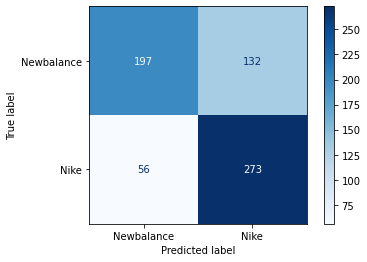

In [64]:
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format='d');
plt.savefig('visuals/confusion_matrix_cv_forest.jpeg')

In [60]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

  Newbalance       0.78      0.60      0.68       329
        Nike       0.67      0.83      0.74       329

    accuracy                           0.71       658
   macro avg       0.73      0.71      0.71       658
weighted avg       0.73      0.71      0.71       658



### Get the report of the predictions including precision, accuracy, etc. 